# HEK293 identification statistics

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline
import collections
import itertools
import string

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import pyteomics.auxiliary
import seaborn as sns
import tqdm
from matplotlib_venn import venn3, venn3_circles

from ann_solo import reader, spectrum, util

In [3]:
# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)    # single-column figure

In [4]:
tqdm.tqdm = tqdm.tqdm_notebook

In [5]:
def extract_time_from_log(filename):
    with open(filename, 'r') as f_in:
        for line in f_in:
            if line.startswith('user'):
                # user time
                usertime = line.split()[1]
                minutes = int(usertime[:usertime.find('m')])
                seconds = float(usertime[usertime.find('m') + 1: usertime.rfind('s')])
                usertime = minutes * 60 + seconds
                # sys time
                line = next(f_in)
                systime = line.split()[1]
                minutes = int(systime[:systime.find('m')])
                seconds = float(systime[systime.find('m') + 1: systime.rfind('s')])
                systime = minutes * 60 + seconds
                
                return usertime + systime

In [6]:
def read_spectrast_psms(filename):
    psms = []
    psms_df = pd.read_csv(filename, sep='\t', header=0)
    for psm_tuple in psms_df.itertuples(False):
        sequence, charge = psm_tuple.ID.split('/')
        query_spectrum = spectrum.Spectrum(psm_tuple._0, psm_tuple.MzDiff,
                                           int(charge))
        psm = spectrum.SpectrumMatch(query_spectrum,
                                     search_engine_score=psm_tuple.Dot)
        psm.sequence = sequence
        psm.calc_mass_to_charge = 0
        psm.is_decoy = 'DECOY_' in psm_tuple.Proteins
        psms.append(psm)
    return psms

def read_msfragger_psms(filename):
    psms = []
    psms_df = pd.read_csv(
        filename, sep='\t', header=None, names=[
            'ScanID', 'Precursor neutral mass (Da)',
            'Retention time (minutes)', 'Precursor charge', 'Hit rank',
            'Peptide Sequence', 'Upstream Amino Acid', 'Downstream Amino Acid',
            'Protein', 'Matched fragment ions',
            'Total possible number of matched theoretical fragment ions',
            'Neutral mass of peptide (including any variable modifications) (Da)',
            'Mass difference', 'Number of tryptic termini',
            'Number of missed cleavages', 'Variable modifications detected',
            'Hyperscore', 'Next score', 'Intercept of expectation model',
            'Slope of expectation model'])
    for psm_tuple in psms_df.itertuples(False):
        charge = psm_tuple._3
        mz = psm_tuple._12 / charge
        query_spectrum = spectrum.Spectrum(psm_tuple.ScanID, mz, charge, psm_tuple._2)
        psm = spectrum.SpectrumMatch(query_spectrum,
                                     search_engine_score=psm_tuple.Hyperscore)
        psm.sequence = psm_tuple._5
        psm.calc_mass_to_charge = 0
        psm.is_decoy = 'decoy_' in psm_tuple.Protein
        psms.append(psm)
    return psms

In [7]:
def psms_to_df(psms):
    sequences, ids, scores, charges, exp_masses, calc_masses, decoys = ([] for _ in range(7))
    for psm in psms:
        sequences.append(psm.sequence)
        ids.append(psm.query_id)
        scores.append(psm.search_engine_score)
        charges.append(psm.charge)
        exp_masses.append(psm.exp_mass_to_charge)
        calc_masses.append(psm.calc_mass_to_charge)
        decoys.append(psm.is_decoy)
    
    return pd.DataFrame({'sequence': sequences, 'PSM_ID': ids,
                         'search_engine_score[1]': scores, 'charge': charges,
                         'exp_mass_to_charge': exp_masses,
                         'calc_mass_to_charge': calc_masses,
                         'opt_ms_run[1]_cv_MS:1002217_decoy_peptide': decoys})

In [8]:
max_fdr = 0.01
tol_mass = 0.1
tol_mode = 'Da'
min_group_size = 20

In [9]:
hek293_dir = '../data/processed/hek293'

In [10]:
num_ids = []
runtimes = []
psms = collections.defaultdict(list)
total = 24 * 2 * 6    # 24 raw files * 2 (IDs & log) * 6 (search engine combos)
with tqdm.tqdm(desc='Files processed', unit='files', total=total) as pbar:
    for search_engine in ('ann-solo', 'spectrast', 'msfragger'):
        for search_mode in ('oms', 'std'):
            for filename in os.listdir(
                    os.path.join(hek293_dir, search_engine, search_mode)):
                filename_full = os.path.join(hek293_dir, search_engine,
                                             search_mode, filename)
                _, ext = os.path.splitext(filename_full)
                if ext == '.log':
                    runtimes.append((
                        search_engine, search_mode,
                        os.path.splitext(filename)[0],
                        extract_time_from_log(filename_full)))
                    pbar.update(1)
                elif ext in ('.mztab', '.txt', '.tsv'):
                    if ext == '.mztab':  # ANN-SoLo
                        file_psms = reader.read_mztab_psms(filename_full)
                    elif ext == '.txt':  # SpectraST
                        file_psms = psms_to_df(list(util.filter_group_fdr(
                            read_spectrast_psms(filename_full),
                            max_fdr, tol_mass, tol_mode, min_group_size)))
                    elif ext == '.tsv':  # MSFragger
                        file_psms = psms_to_df(list(util.filter_group_fdr(
                            read_msfragger_psms(filename_full),
                            max_fdr, tol_mass, tol_mode, min_group_size)))
                    psms[(search_engine, search_mode)].append(file_psms)
                    num_ids.append((search_engine, search_mode,
                                    os.path.splitext(filename)[0],
                                    len(file_psms)))
                    pbar.update(1)

num_ids_df = pd.DataFrame.from_records(
    num_ids, columns=['search_engine', 'search_mode', 'filename', 'psms'])
time_df = pd.DataFrame.from_records(
    runtimes, columns=['search_engine', 'search_mode', 'filename', 'time'])
stats = (pd.merge(num_ids_df, time_df,
                 on=['search_engine', 'search_mode', 'filename'])
         .sort_values(['search_engine', 'search_mode', 'filename'])
         .reset_index(drop=True))

summary = (stats.groupby(['search_engine', 'search_mode'])
           .agg({'psms': 'sum', 'time': 'mean'}))
summary['time'] = summary['time'] / 60

psms_df, peptides = [], collections.defaultdict(dict)
for (search_engine, search_mode), psm_list in psms.items():
    sequences = set(pd.concat(psm_list)['sequence']
                   .str.replace(r'n?\[\d+\]', '').unique())
    psms_df.append((search_engine, search_mode, len(sequences)))
    peptides[search_mode][search_engine] = sequences
psms_df = pd.DataFrame.from_records(
    psms_df, index=['search_engine', 'search_mode'],
    columns=['search_engine', 'search_mode', 'peptides'])
summary = summary.join(psms_df)

HBox(children=(IntProgress(value=0, description='Files processed', max=288), HTML(value='')))

/Users/Wout/.conda/envs/ann-solo/lib/python3.6/site-packages/pyteomics/auxiliary/target_decoy.py:79: RuntimeWarning: divide by zero encountered in true_divide
  q = tfalse / (ind - cumsum) / ratio


In [11]:
summary

psms         time  peptides
search_engine search_mode                               
ann-solo      oms          647469   108.531303    153605
              std          352938    24.015849    105870
msfragger     oms          526027    34.745542    126364
              std          344998     0.697961    104672
spectrast     oms          473729  1276.663253    112375
              std          369079     5.205294    102077

In [12]:
# export LaTeX table
with open('../../reports/rev/tab-hek293_stats.tex', 'w') as f_out:
    f_out.write('\\begin{tabularx}{0.5\\textwidth}{Xrrr}\n')
    f_out.write('\\toprule\n')
    f_out.write('Search engine & Time (\\si{\\minute}) & \\#~SSMs & \\#~Peptides \\\\\n')
    f_out.write('\\midrule\n')
    f_out.write('\\multicolumn{4}{l}{\\emph{Standard search}} \\\\\n')
    for search_engine in ('MSFragger', 'SpectraST', 'ANN-SoLo'):
        num_psms, time, num_pep = summary.loc[search_engine.lower(), 'std']
        f_out.write(f'\\mbox{{{search_engine}}} & \\num{{{round(time, 1)}}} & '
                    f'\\num{{{int(num_psms)}}} & \\num{{{int(num_pep)}}} \\\\\n')
    f_out.write('\\addlinespace\n')
    f_out.write('\\multicolumn{4}{l}{\\emph{Open search}} \\\\\n')
    for search_engine in ('MSFragger', 'SpectraST', 'ANN-SoLo'):
        num_psms, time, num_pep = summary.loc[search_engine.lower(), 'oms']
        f_out.write(f'\\mbox{{{search_engine}}} & \\num{{{round(time, 1)}}} & '
                    f'\\num{{{int(num_psms)}}} & \\num{{{int(num_pep)}}} \\\\\n')
    f_out.write('\\bottomrule\n')
    f_out.write('\\end{tabularx}\n')

In [13]:
for search_mode, search_engines in peptides.items():
    for search_engine, sequences in search_engines.items():
        peptides[search_mode][search_engine] = set([pep.replace('I', 'L') for pep in sequences])

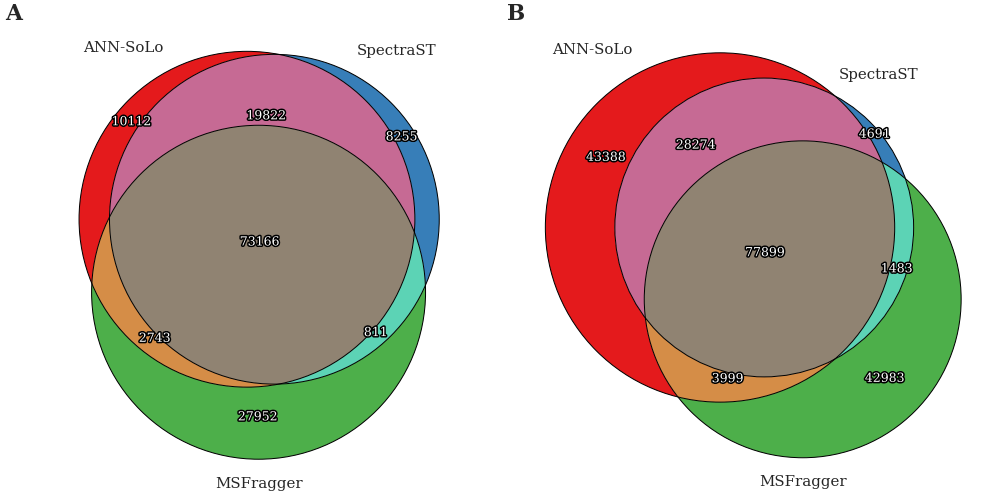

In [14]:
height = 7
width = height * 2
fig, axes = plt.subplots(1, 2, figsize=(width, height))

label_map = {'ann-solo': 'ANN-SoLo', 'msfragger': 'MSFragger',
             'spectrast': 'SpectraST'}
for i, (search_mode, ax) in enumerate(zip(('std', 'oms'), axes)):
    v = venn3(peptides[search_mode].values(),
              [label_map[key] for key in peptides[search_mode].keys()],
              set_colors=[next(ax._get_lines.prop_cycler)['color'],
                          next(ax._get_lines.prop_cycler)['color'],
                          next(ax._get_lines.prop_cycler)['color']],
              alpha=1, ax=ax)
    # make sure the numbers are legible
    for text in v.subset_labels:
        text.set_color('white')
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                               path_effects.Normal()])
    c = venn3_circles(peptides[search_mode].values(), linewidth=1.0, ax=ax)
    
    ax.annotate(string.ascii_uppercase[i], xy=(0.5 * i, 1), xytext=(5, -20),
                xycoords='figure fraction', textcoords='offset pixels',
                fontsize='xx-large', weight='bold')
    
plt.tight_layout()

plt.savefig('hek293_peptides_venn.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [15]:
def get_mass_groups(psms, tol_mass, tol_mode):
    # start with the highest ranked PSM
    mass_groups = []
    psms_remaining = psms.sort_values('search_engine_score[1]', ascending=False)
    while len(psms_remaining) > 0:
        # find all remaining PSMs within the precursor mass window
        mass_diff = psms_remaining['mass_diff'].iloc[0]
        if tol_mass is None or tol_mode not in ('Da', 'ppm'):
            psms_selected = psms_remaining
        elif tol_mode == 'Da':
            psms_selected = \
                psms_remaining[(psms_remaining['mass_diff'] - mass_diff).abs()
                               <= tol_mass]
        elif tol_mode == 'ppm':
            psms_selected = \
                psms_remaining[(psms_remaining['mass_diff'] - mass_diff).abs()
                               / psms_remaining['exp_mass_to_charge'] * 10 ** 6
                               <= tol_mass]
        mass_groups.append(psms_selected)
        # exclude the selected PSMs from further selections
        psms_remaining.drop(psms_selected.index, inplace=True)

    mass_group_stats = []
    for mass_group in mass_groups:
        mass_group_stats.append((mass_group['mass_diff'].median(),
                                 mass_group['mass_diff'].mean(),
                                 len(mass_group)))
    mass_group_stats = pd.DataFrame.from_records(
        mass_group_stats, columns=['mass_diff_median', 'mass_diff_mean', 'num_psms'])
    return mass_group_stats

In [16]:
for psms_key, psms_list in psms.items():
    psms[psms_key] = pd.concat(psms_list, ignore_index=True)

In [17]:
search_engines = ('ANN-SoLo', 'SpectraST', 'MSFragger')
for search_engine in search_engines:
    psms_oms = psms[(search_engine.lower(), 'oms')]
    psms_oms['mass_diff'] = (
        (psms_oms['exp_mass_to_charge'] - psms_oms['calc_mass_to_charge'])
        * psms_oms['charge'])

In [18]:
mass_groups = {}
for search_engine in search_engines:
    psms_oms = psms[(search_engine.lower(), 'oms')]
    psms_oms['mass_diff'] = (
        (psms_oms['exp_mass_to_charge'] - psms_oms['calc_mass_to_charge'])
        * psms_oms['charge'])
    mass_groups[search_engine.lower()] = get_mass_groups(psms_oms, tol_mass, tol_mode)

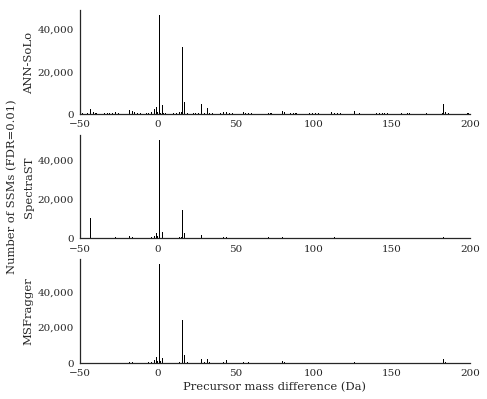

In [19]:
width = 7
height = width / 1.618 / 2 * len(search_engines)
fig, axes = plt.subplots(len(search_engines), 1, sharex=True, figsize=(width, height))

for ax, search_engine in zip(axes, search_engines):
    mass_group = mass_groups[search_engine.lower()]
    mask = mass_group['mass_diff_median'].abs() > tol_mass   # exclude unmodified PSMs
    ax.bar(mass_group[mask]['mass_diff_median'], mass_group[mask]['num_psms'],
           width=0.4, log=False, color='black')

    ax.set_xlim((-50, 200))

    # format y-axis numbers
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,g}'))
    
    ax.set_ylabel(search_engine)

    sns.despine(ax=ax)
    
# set tick labels at nice positions
axes[-1].xaxis.set_major_locator(mticker.MultipleLocator(50))
axes[-1].set_xlabel('Precursor mass difference (Da)')

ax = fig.add_subplot(111, frameon=False)
ax.grid(False)
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_ylabel(f'Number of SSMs (FDR={max_fdr})', labelpad=40)

plt.savefig('mass_diff.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()